### Sentiment Analysis of Statements about Finances

Saved as 'distilbert-base-uncased-Finanacial_Sentiment_Analysis' on my HuggingFace profile

Source for the Datasets: 

*https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

*https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

### Exploratory Data Analysis & Preprocessing in Pandas

Importing the Necessary Libraries for the Entire Project

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from pathlib import Path

import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

import datasets
from datasets import Dataset, DatasetDict, load_metric

import transformers
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer, AutoModel
from transformers import TrainingArguments, Trainer, AdamW, get_scheduler, set_seed, DataCollatorWithPadding

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Versions of Libraries Used

In [2]:
print("Pandas:".ljust(18), pd.__version__)
print("NumPy:".ljust(18), np.__version__)
print("Torch:".ljust(18), torch.__version__)

Pandas:            1.4.3
NumPy:             1.22.4
Torch:             1.12.1


#### Ingest First Dataset & Preprocessing it

In [3]:
data1 = pd.read_csv('~/Documents/nlpnn/Datasets/Finanacial Sentiment Analysis/data.csv', engine="c")

data1.dropna(inplace=True)

data1['Sentence'] = data1['Sentence'].str.strip()
data1['Sentiment'] = data1['Sentiment'].str.strip()

data1.rename(columns={'Sentence' : 'text', 'Sentiment' : 'label'}, inplace=True)
data1.drop_duplicates(inplace=True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5836 non-null   object
 1   label   5836 non-null   object
dtypes: object(2)
memory usage: 136.8+ KB


#### Ingest Second Dataset & Preprocessing it

In [4]:
data2 = pd.read_csv('~/Documents/nlpnn/Datasets/Finanacial Sentiment Analysis/all-data.csv', 
                    encoding_errors='ignore', 
                    engine="c", 
                    header=None, 
                    names=['label', 'text'])

data2['label'] = data2['label'].str.strip()
data2['text'] = data2['text'].str.strip()

data2.drop_duplicates(inplace=True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4840 non-null   object
 1   text    4840 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


#### Concatenate Both Datasets

In [5]:
data = pd.concat([data1, data2]).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10676 entries, 0 to 10675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10676 non-null  object
 1   label   10676 non-null  object
dtypes: object(2)
memory usage: 166.9+ KB


#### Histogram of Text Lengths

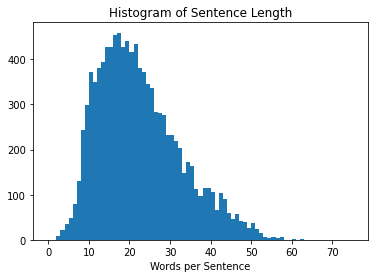

In [6]:
data['Sentence Length'] = data['text'].str.split().apply(len)
n=75
data.hist('Sentence Length', grid=False, bins=n, range=(0,n))

plt.suptitle('')
plt.title('Histogram of Sentence Length')
plt.ylabel('')
plt.xlabel('Words per Sentence')
plt.show()

##### Visualize: Description Lengths (By Output Class)

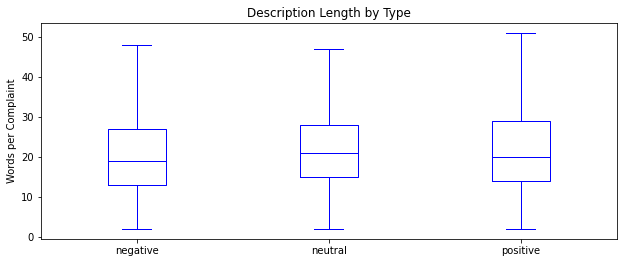

In [7]:
data.boxplot("Sentence Length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,4))

plt.suptitle('')
plt.title('Description Length by Type')
plt.xlabel('')
plt.ylabel('Words per Complaint')
plt.show()

#### Remove overly Length Sentences & Remove Unnecessary Feature

In [8]:
data = data[data['Sentence Length'] < 59]

data = data.drop(columns=['Sentence Length'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10670 entries, 0 to 10675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10670 non-null  object
 1   label   10670 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


##### Quick Look at Updated Class Distribution

In [9]:
results_data = pd.Series(dtype=int, name='result_count')
results_data = data['label'].value_counts()

print(results_data, '\n\nTotal:', results_data.sum())

neutral     5991
positive    3215
negative    1464
Name: label, dtype: int64 

Total: 10670


#### Final Prepocessing Before loading it to Datasets

In [10]:
unique_classes = data['label'].unique()

unique_class_converter = {unique_classes[x] : x for x in range(len(unique_classes))}

print(unique_class_converter)

data['label'].replace(unique_class_converter, inplace=True)

data.head()

{'positive': 0, 'negative': 1, 'neutral': 2}


,text,label
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,2
4,The Swedish buyout firm has sold its remaining...,2


### Regular Project

#### Basic Constants/Values

In [11]:
model_ckpt = 'distilbert-base-uncased'
device="cpu"
max_input_length = int(round(80*1.3,0))
set_seed(42)
batch_size = 64
print(max_input_length)

104


#### Convert Pandas DataFrame to Dataset; Then Split into Train/Test/Valid Datasets

In [12]:
# Convert pandas dataframe to a dataset
dataset = Dataset.from_pandas(data)

# Split the datasetdict into train/test/valid subsets
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

# Combine the train/test/valid into one datasetdict
dataset = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

print('training data shape:', dataset['train'].shape)
print('testing data shape:', dataset['test'].shape)
print('validation data shape:', dataset['valid'].shape)
print(dataset['train'].features)

training data shape: (8536, 3)
testing data shape: (1067, 3)
validation data shape: (1067, 3)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Tokenize Entire Dataset

In [13]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=max_input_length, return_tensors="np")

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = dataset.map(tokenize, batched=True, batch_size=None)

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['valid'].shape)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

training data shape: (8536, 5)
testing data shape: (1067, 5)
validation data shape: (1067, 5)


#### Check Results of Tokenization

In [14]:
print(encoded_data['train'].features)
print(encoded_data['train'])

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 8536
})


#### Instantiate Model

In [15]:
num_labels=len(unique_classes)

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
model.config.num_labels

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

3

#### Ensure that git lfs is Installed; Remember to Enter Access Token

In [16]:
!git lfs install

# HuggingFace Access Token ...

Git LFS initialized.


#### Define Function to Compute Metrics

In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1_score": f1}

#### Instantiate Data Collator

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### Instantiate TrainingArguments

In [19]:
num_of_epochs = 3
logging_steps = (len(encoded_data['train']) // batch_size)
learning_rate=2e-5
label_names = unique_classes
steps = 100

model_name = f"{model_ckpt}-Finanacial_Sentiment_Analysis"

training_args = TrainingArguments(output_dir=model_name,
                        num_train_epochs=num_of_epochs,
                        learning_rate=learning_rate,
                        per_device_train_batch_size=batch_size, 
                        per_device_eval_batch_size=batch_size, 
                        weight_decay=0.01,
                        log_level="error",
                        logging_strategy='epoch', 
                        hub_strategy="checkpoint",
                        evaluation_strategy="epoch",
                        save_strategy="epoch",
                        save_total_limit=5,
                        load_best_model_at_end=True,
                        metric_for_best_model="f1_score",
                        greater_is_better=True,
                        logging_first_step=True,
                        group_by_length=True,
                        disable_tqdm=False,
                        push_to_hub=True)

#### Instantiate Optimizer (& Learning Rate Scheduler)

In [20]:
optimizer_name = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_of_epochs * len(encoded_data['train'])

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer_name, num_warmup_steps=0, num_training_steps=num_training_steps
)

optimizer = [optimizer_name, lr_scheduler]

#### Subclass Trainer to Correctly Compute Loss Function

In [21]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [22]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['valid'], 
                  data_collator=data_collator,
                  optimizers=optimizer,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-Finanacial_Sentiment_Analysis into local empty directory.


#### Train Model

In [23]:
trainer.train()

  0%|          | 0/402 [00:00<?, ?it/s]

{'loss': 1.1124, 'learning_rate': 1.9999218994064354e-05, 'epoch': 0.01}
{'loss': 0.5501, 'learning_rate': 1.989534520462356e-05, 'epoch': 1.0}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 0.3857389986515045, 'eval_accuracy': 0.7656982193064668, 'eval_f1_score': 0.7614242410331038, 'eval_runtime': 235.0767, 'eval_samples_per_second': 4.539, 'eval_steps_per_second': 0.072, 'epoch': 1.0}
{'loss': 0.3062, 'learning_rate': 1.9790690409247112e-05, 'epoch': 2.0}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 0.32900911569595337, 'eval_accuracy': 0.8322399250234301, 'eval_f1_score': 0.8349432757741744, 'eval_runtime': 231.5048, 'eval_samples_per_second': 4.609, 'eval_steps_per_second': 0.073, 'epoch': 2.0}
{'loss': 0.2347, 'learning_rate': 1.9686035613870666e-05, 'epoch': 3.0}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 0.3071199357509613, 'eval_accuracy': 0.8425492033739457, 'eval_f1_score': 0.8470211920321009, 'eval_runtime': 231.0708, 'eval_samples_per_second': 4.618, 'eval_steps_per_second': 0.074, 'epoch': 3.0}
{'train_runtime': 17675.2787, 'train_samples_per_second': 1.449, 'train_steps_per_second': 0.023, 'train_loss': 0.3650743406803454, 'epoch': 3.0}


TrainOutput(global_step=402, training_loss=0.3650743406803454, metrics={'train_runtime': 17675.2787, 'train_samples_per_second': 1.449, 'train_steps_per_second': 0.023, 'train_loss': 0.3650743406803454, 'epoch': 3.0})

### Assessing the Results of the Fine-Tuned Model

#### Calculate Predictions for Fine-Tuned Model

In [24]:
output_predictions = trainer.predict(encoded_data['valid'])

output_predictions.metrics

  0%|          | 0/17 [00:00<?, ?it/s]

{'test_loss': 0.3071199357509613,
 'test_accuracy': 0.8425492033739457,
 'test_f1_score': 0.8470211920321009,
 'test_runtime': 233.8672,
 'test_samples_per_second': 4.562,
 'test_steps_per_second': 0.073}

#### Extract Last Hidden States to Create Feature Matrix

In [25]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}   
    with torch.no_grad():
        last_hidden_state = model(**inputs)[0]
    return {"hidden_state" : last_hidden_state[:,0].cpu().numpy()}

encoded_data.set_format("torch", columns=['input_ids', 'attention_mask', 'label']) 

hidden_data = encoded_data.map(extract_hidden_states, batched=True)
print(hidden_data)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 8536
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1067
    })
    valid: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1067
    })
})


#### Create Feature Matrix

In [26]:
X_train = np.array(hidden_data['train']['hidden_state'])
X_valid = np.array(hidden_data['valid']['hidden_state'])
y_train = np.array(hidden_data['train']['label'])
y_valid = np.array(hidden_data['valid']['label'])
X_train.shape, X_valid.shape

((8536,), (1067,))

#### Define Function to Display Confusion Matrix

In [27]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(11, 11))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.show()

#### Convert Logits to Integers & Display Confusion Matrix

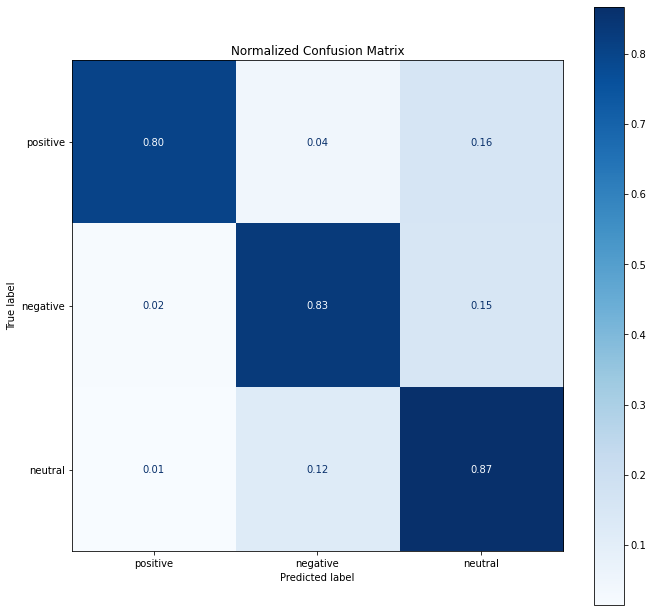

In [28]:
y_preds = np.argmax(output_predictions.predictions, axis=1)
names_of_labels = label_names

plot_confusion_matrix(y_preds, y_valid, names_of_labels)

### Final Steps

#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [29]:
trainer.push_to_hub(commit_message="All Dunn!!!")

#### Save Datasets to File

In [30]:
#dataset['train'].to_csv('~/Documents/nlpnn/Datasets/Finanacial Sentiment Analysis/train_ds.csv')
#dataset['test'].to_csv('~/Documents/nlpnn/Datasets/Finanacial Sentiment Analysis/test_ds.csv')
#dataset['valid'].to_csv('~/Documents/nlpnn/Datasets/Finanacial Sentiment Analysis/eval_ds.csv')